
# 🌲 독성예측 — **class_weight=None** + **중요도 하위 비트 프루닝** + Bagging + OOF 임계값 최적화 + 예측

- **데이터**: `train.csv` (SMILES 제외, 수치형 + ECFP/FCFP/PTFP, No PCA)  
- **가중치**: `class_weight=None` (기본값)  
- **프루닝**: RandomForest 중요도 기반 **하위 p% 비트 일괄 제거** (기본 20%)  
- **모델**: 같은 하이퍼파라미터로 **배깅(N개, 시드만 다르게)** → 확률 평균  
- **튜닝**: **GridSearch 없이**, 5-Fold **OOF 확률**로 **F1 최대 임계값** 탐색  
- **출력**: `predict_input.csv` → `predict_output.csv` (`SMILES`, `output`)


In [1]:

# !pip install -q scikit-learn pandas numpy joblib matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TRAIN_CANDIDATES = ["/mnt/data/train.csv", "./train.csv", "/content/train.csv"]
PRED_CANDIDATES  = ["/mnt/data/predict_input.csv", "./predict_input.csv", "/content/predict_input.csv"]

# 배깅 개수 (시간 대비 3~5 권장)
N_MODELS = 5

# 중요도 하위 프루닝 비율 (예: 0.2 → 하위 20% 제거)
PRUNE_RATIO = 0.20


## 1) 데이터 로드 & 피처 구성 (SMILES 제외, No PCA)

In [2]:

train_path = next((p for p in TRAIN_CANDIDATES if Path(p).exists()), None)
assert train_path, "train.csv 파일이 필요합니다."
df = pd.read_csv(train_path)
print(f"[train] {train_path}  shape={df.shape}")

# 라벨 정리
df['label_num'] = pd.to_numeric(df['label'], errors='coerce')
df = df[df['label_num'].isin([0,1])].copy()
y = df['label_num'].astype(int).to_numpy()

# 피처 구성
exclude_cols = {'label','label_num','SMILES'}
base_feats = [c for c in ['MolWt','clogp','sa_score','qed'] if c in df.columns]
fp_cols = [c for c in df.columns if any(k in c.upper() for k in ['ECFP','FCFP','PTFP'])]
feature_cols = [c for c in (base_feats + fp_cols) if c not in exclude_cols]

X_df = df[feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0)
X = X_df.to_numpy()

print(f"Samples={X.shape[0]}, Features={X.shape[1]}  (base={len(base_feats)}, fp={len(fp_cols)})")
print("Label distribution:\n", pd.Series(y).value_counts().sort_index())


[train] ./train.csv  shape=(8349, 3078)
Samples=8349, Features=3076  (base=4, fp=3072)
Label distribution:
 0    3807
1    4542
Name: count, dtype: int64


## 2) 베이스 하이퍼파라미터 (class_weight=None)

In [3]:

base_params = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    class_weight=None,   # ✅ 기본값 사용
    random_state=RANDOM_STATE
)
print("Base RF params:", base_params)


Base RF params: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'n_jobs': -1, 'class_weight': None, 'random_state': 42}


## 3) 중요도 기반 하위 p% 프루닝 (한 번 학습해서 중요도 산출)

In [4]:

# 전체 데이터로 단일 RF를 한 번 학습해 중요도 산출 (빠르고 단순)
rf_for_importance = RandomForestClassifier(**base_params)
rf_for_importance.fit(X, y)
importances = rf_for_importance.feature_importances_

# 하위 PRUNE_RATIO 비율의 피처 인덱스 제거
n_feats = X.shape[1]
n_prune = int(n_feats * PRUNE_RATIO)
order = np.argsort(importances)  # 오름차순: 하위 → 상위
prune_idx = order[:n_prune]
keep_idx = order[n_prune:]

selected_features = [feature_cols[i] for i in keep_idx]
X_pruned = X[:, keep_idx]

print(f"Total features: {n_feats}")
print(f"Pruned (bottom {PRUNE_RATIO*100:.0f}%): {n_prune}")
print(f"Kept features: {len(keep_idx)}")
print("예시 유지 피처 상위 10개:", selected_features[:10])

# 선택 피처 저장
pd.Series(selected_features, name="selected_feature").to_csv("selected_features_after_pruning.csv", index=False)
print("✅ 선택 피처 저장: selected_features_after_pruning.csv")


Total features: 3076
Pruned (bottom 20%): 615
Kept features: 2461
예시 유지 피처 상위 10개: ['ecfp_377', 'ecfp_876', 'ecfp_152', 'ptfp_243', 'ecfp_991', 'fcfp_830', 'fcfp_161', 'fcfp_625', 'ecfp_382', 'fcfp_575']
✅ 선택 피처 저장: selected_features_after_pruning.csv


## 4) 5-Fold OOF 기반 임계값 탐색 (프루닝된 피처로 배깅)

[Fold 1] done.
[Fold 2] done.
[Fold 3] done.
[Fold 4] done.
[Fold 5] done.
★ Best Threshold t* = 0.475 | OOF F1 (Pruned+Bagging) = 0.8166


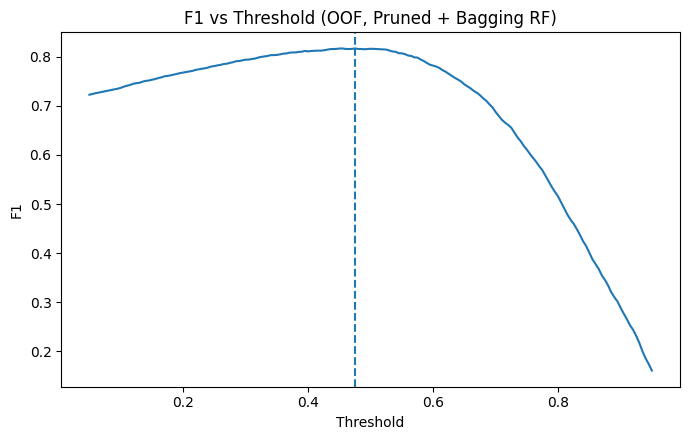

In [5]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = np.zeros(X_pruned.shape[0], dtype=float)

def fit_one_rf(seed, X_tr, y_tr):
    params = base_params.copy()
    params['random_state'] = seed
    clf = RandomForestClassifier(**params)
    # 부트스트랩 배깅
    rng = np.random.RandomState(seed)
    boot_idx = rng.choice(len(X_tr), size=len(X_tr), replace=True)
    clf.fit(X_tr[boot_idx], y_tr[boot_idx])
    return clf

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_pruned, y), 1):
    X_tr, y_tr = X_pruned[tr_idx], y[tr_idx]
    X_va, y_va = X_pruned[va_idx], y[va_idx]

    proba_sum = np.zeros(len(va_idx), dtype=float)
    for m in range(N_MODELS):
        seed = RANDOM_STATE + 1000*fold + m
        clf = fit_one_rf(seed, X_tr, y_tr)
        proba_sum += clf.predict_proba(X_va)[:,1]
    oof_proba[va_idx] = proba_sum / N_MODELS
    print(f"[Fold {fold}] done.")

# 임계값 스윕
ts = np.linspace(0.05, 0.95, 181)
f1s = np.array([f1_score(y, (oof_proba >= t).astype(int)) for t in ts])
best_idx = int(np.argmax(f1s))
best_t = float(ts[best_idx])
best_f1 = float(f1s[best_idx])
print(f"★ Best Threshold t* = {best_t:.3f} | OOF F1 (Pruned+Bagging) = {best_f1:.4f}")

plt.figure(figsize=(7,4.5))
plt.plot(ts, f1s); plt.axvline(best_t, linestyle='--')
plt.title("F1 vs Threshold (OOF, Pruned + Bagging RF)")
plt.xlabel("Threshold"); plt.ylabel("F1"); plt.tight_layout(); plt.show()


## 5) 전체 데이터로 최종 배깅 모델 재학습 & 저장 (프루닝 유지)

In [6]:

final_models = []
for m in range(N_MODELS):
    seed = RANDOM_STATE + 777*m
    clf = fit_one_rf(seed, X_pruned, y)
    final_models.append(clf)

bundle = {
    "models": final_models,
    "feature_idx": keep_idx,           # 선택된 피처 인덱스
    "selected_features": selected_features,
    "best_t": best_t,
    "params": base_params,
    "n_models": N_MODELS,
    "prune_ratio": PRUNE_RATIO
}
joblib.dump(bundle, "rf_bagging_pruned_bundle.joblib")
print("✅ 저장 완료: rf_bagging_pruned_bundle.joblib")

# 참고: 학습 데이터 평가 (임계값 적용)
proba_train = np.mean([m.predict_proba(X_pruned)[:,1] for m in final_models], axis=0)
pred_train = (proba_train >= best_t).astype(int)
print("\n[Training Data Evaluation]")
print(classification_report(y, pred_train, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y, pred_train))


✅ 저장 완료: rf_bagging_pruned_bundle.joblib

[Training Data Evaluation]
              precision    recall  f1-score   support

           0     0.9832    0.9546    0.9687      3807
           1     0.9628    0.9863    0.9744      4542

    accuracy                         0.9719      8349
   macro avg     0.9730    0.9705    0.9716      8349
weighted avg     0.9721    0.9719    0.9718      8349

Confusion Matrix:
[[3634  173]
 [  62 4480]]


## 6) predict_input.csv → predict_output.csv (SMILES, output)

In [ ]:

pred_path = next((p for p in PRED_CANDIDATES if Path(p).exists()), None)
assert pred_path, "predict_input.csv 파일이 필요합니다."
pred_df = pd.read_csv(pred_path)
print(f"[predict_input] {pred_path}  shape={pred_df.shape}")

# 동일 전처리 + 같은 피처 선택 적용
X_base_pred = pred_df[base_feats].replace([np.inf,-np.inf], np.nan).fillna(0) if base_feats else None
X_fp_pred   = pred_df[fp_cols].replace([np.inf,-np.inf], np.nan).fillna(0) if fp_cols else None

if X_base_pred is not None and X_fp_pred is not None:
    X_pred_full = np.hstack([X_base_pred.values, X_fp_pred.values])
elif X_fp_pred is not None:
    X_pred_full = X_fp_pred.values
elif X_base_pred is not None:
    X_pred_full = X_base_pred.values
else:
    raise ValueError("예측에 사용할 피처가 없습니다.")

# 프루닝에서 선택된 피처만 사용
X_pred = X_pred_full[:, keep_idx]

# 앙상블 확률 평균 → 임계값 적용
proba_pred = np.mean([m.predict_proba(X_pred)[:,1] for m in final_models], axis=0)
pred_label = (proba_pred >= best_t).astype(int)

out_df = pd.DataFrame({
    "SMILES": pred_df["SMILES"],
    "output": pred_label
})
out_df.to_csv("predict_output.csv", index=False)
print("✅ 예측 결과 저장 완료: predict_output.csv")
out_df.head()
